In [7]:
"""
======================================================================
Variational with birth and merge proposals for DP mixtures of Gaussians
======================================================================

How to train a DP mixture model.

We'll show that despite diverse, poor quality initializations, our proposal moves that insert new clusters (birth) and remove redundant clusters (merge) can consistently recover the same ideal posterior with 8 clusters.

"""
import bnpy
import numpy as np
import os
import sys
import pdb

import matplotlib.pyplot as plt
import seaborn as sns

# sphinx_gallery_thumbnail_number = 2

FIG_SIZE = (3, 3)
plt.rcParams['figure.figsize'] = FIG_SIZE

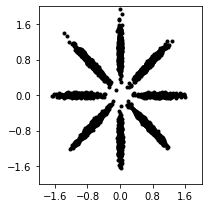

In [8]:
###############################################################################
# Read dataset from file.

dataset_path = os.path.join(bnpy.DATASET_PATH, 'AsteriskK8')
dataset = bnpy.data.XData.read_npz(os.path.join(dataset_path, 'x_dataset.npz'))

###############################################################################
#
# Make a simple plot of the raw data

plt.plot(dataset.X[:, 0], dataset.X[:, 1], 'k.')
plt.gca().set_xlim([-2, 2])
plt.gca().set_ylim([-2, 2])
plt.tight_layout()
plt.show()

In [9]:
###############################################################################
#
# Setup: Function for visualization
# ---------------------------------
# Here's a short function to show the learned clusters over time.

def show_clusters_over_time(
        task_output_path=None,
        query_laps=[0, 1, 2, 5, 10, None],
        nrows=2):
    """ Read model snapshots from provided folder and make visualizations

    Post Condition
    --------------
    New matplotlib plot with some nice pictures.
    """
    ncols = int(np.ceil(len(query_laps) // float(nrows)))
    fig_handle, ax_handle_list = plt.subplots(
        figsize=(FIG_SIZE[0] * ncols, FIG_SIZE[1] * nrows),
        nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for plot_id, lap_val in enumerate(query_laps):
        cur_model, lap_val = bnpy.load_model_at_lap(task_output_path, lap_val)
        # Plot the current model
        cur_ax_handle = ax_handle_list.flatten()[plot_id]
        bnpy.viz.PlotComps.plotCompsFromHModel(
            cur_model, Data=dataset, ax_handle=cur_ax_handle)
        cur_ax_handle.set_xticks([-2, -1, 0, 1, 2])
        cur_ax_handle.set_yticks([-2, -1, 0, 1, 2])
        cur_ax_handle.set_xlabel("lap: %d" % lap_val)
    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()    

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 1000 units
  num. batches: 5
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = randexamples
  K = 1 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/trymoves-K=1/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 2 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    0.200/100 after      0 sec. |    154.0 MiB | K    1 | loss  1.109702670e+00 |  
    0.400/100 after      0 sec. |    154.0 MiB | K    1 | loss  1.104611988e+00 |  
    0.600/100 after      0 sec. |    154.0 MiB | K    1 | loss  1.09986

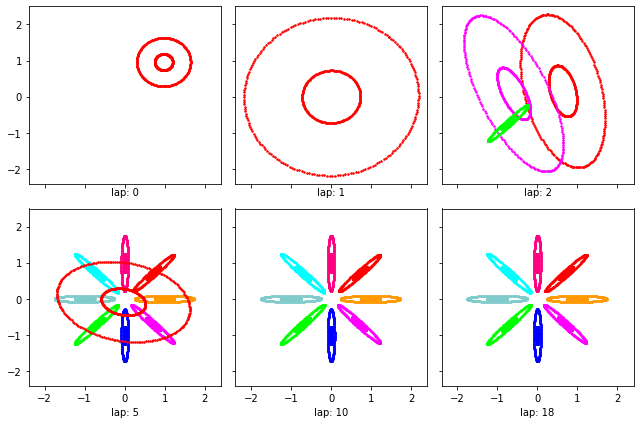

In [10]:
###############################################################################
# Training from K=1 cluster
# -------------------------
# 
# Using 1 initial cluster, with birth and merge proposal moves.
K1_trained_model, K1_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8/trymoves-K=1/',
    nLap=100, nTask=1, nBatch=5,
    sF=0.1, ECovMat='eye',
    K=1, initname='randexamples',
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=2, b_Kfresh=4)

show_clusters_over_time(K1_info_dict['task_output_path'])
#sys.exit()

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 5000 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = randexamples
  K = 4 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/trymoves-K=4/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 2 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    159.1 MiB | K    4 | loss  9.001549009e-01 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 5 (--m_startLap).
BIRTH @ lap 2.00 : Added 8 states. 2/4 succeeded. 2/4 failed eval phase. 0/4 failed build 

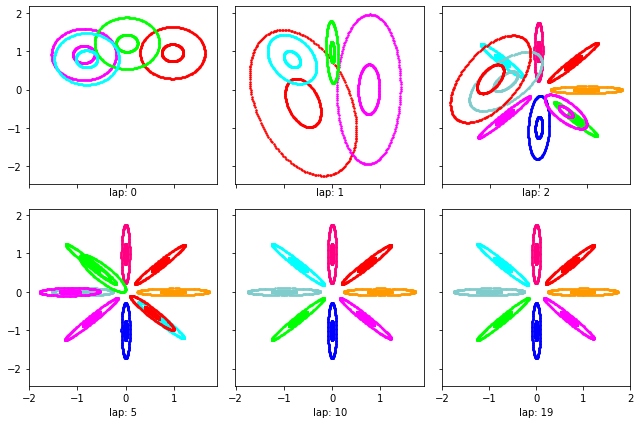

In [11]:
###############################################################################
# Training from K=4 cluster
# -------------------------
# 
# Now using 4 initial clusters, with birth and merge proposal moves.

K4_trained_model, K4_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8/trymoves-K=4/',
    nLap=100, nTask=1, nBatch=1,
    sF=0.1, ECovMat='eye',
    K=4, initname='randexamples',
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=2, b_Kfresh=4)

show_clusters_over_time(K4_info_dict['task_output_path'])

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 5000 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = randexamples
  K = 8 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/trymoves-K=8/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 2 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    166.0 MiB | K    8 | loss  6.479391366e-01 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 5 (--m_startLap).
BIRTH @ lap 2.00 : Added 12 states. 3/8 succeeded. 5/8 failed eval phase. 0/8 failed build

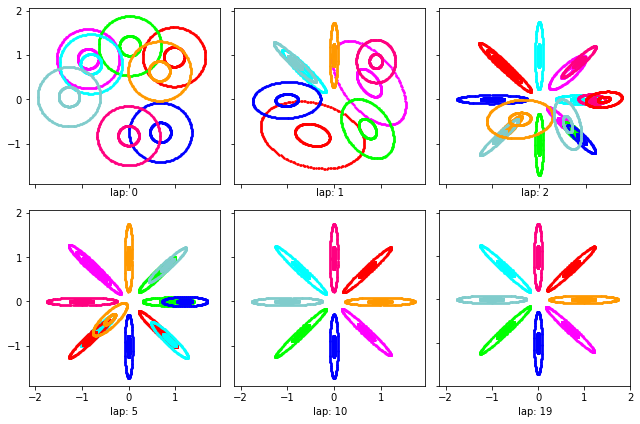

In [12]:
###############################################################################
# Training from K=8 cluster
# -------------------------
# 
# Now using 8 initial clusters

K8_trained_model, K8_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8/trymoves-K=8/',
    nLap=100, nTask=1, nBatch=1,
    sF=0.1, ECovMat='eye',
    K=8, initname='randexamples',
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=2, b_Kfresh=4)

show_clusters_over_time(K8_info_dict['task_output_path'])

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 5000 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = randexamples
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/trymoves-K=25/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 2 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    169.9 MiB | K   25 | loss  4.392317798e-01 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 5 (--m_startLap).
BIRTH @ lap 2.00 : Added 12 states. 4/18 succeeded. 11/18 failed eval phase. 3/18 failed

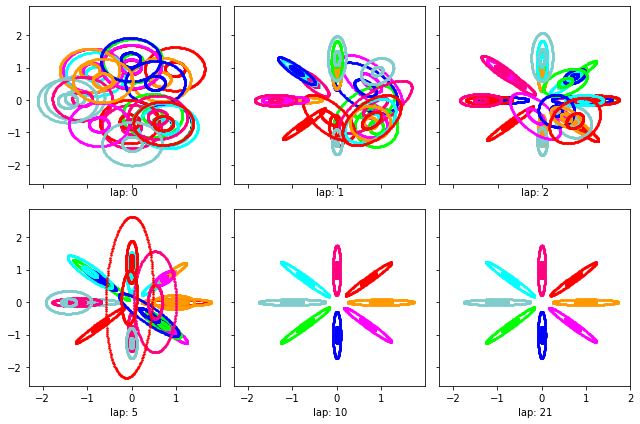

In [13]:
###############################################################################
# Training from K=25 cluster
# --------------------------
# 
# Now using 25 initial clusters

K25_trained_model, K25_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8/trymoves-K=25/',
    nLap=100, nTask=1, nBatch=1,
    sF=0.1, ECovMat='eye',
    K=25, initname='randexamples',
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=2, b_Kfresh=4)

show_clusters_over_time(K25_info_dict['task_output_path'])